# Dash web app with map of Copenhagen with average income for each district

In [1]:
# Import modules
from jupyter_dash import JupyterDash
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import geopandas as gdp
import matplotlib.pyplot as plt
import contextily as ctx

In [2]:
# Import geo data
geo_df = gdp.read_file('districts/bydel.shp')

In [3]:
# Look at the data
geo_df.head()

,id,bydel_nr,navn,areal_m2,geometry
0,6,6.0,Vanløse,6699011.0,"POLYGON ((12.49820 55.68552, 12.49807 55.68545..."
1,8,8.0,Bispebjerg,6830467.0,"POLYGON ((12.53830 55.72644, 12.53846 55.72640..."
2,10,10.0,Amager Vest,19370386.0,"POLYGON ((12.58271 55.66850, 12.58661 55.66783..."
3,3,3.0,Nørrebro,4107635.0,"POLYGON ((12.53704 55.69653, 12.53736 55.69661..."
4,7,7.0,Brønshøj-Husum,8740778.0,"POLYGON ((12.46894 55.69975, 12.46698 55.70024..."


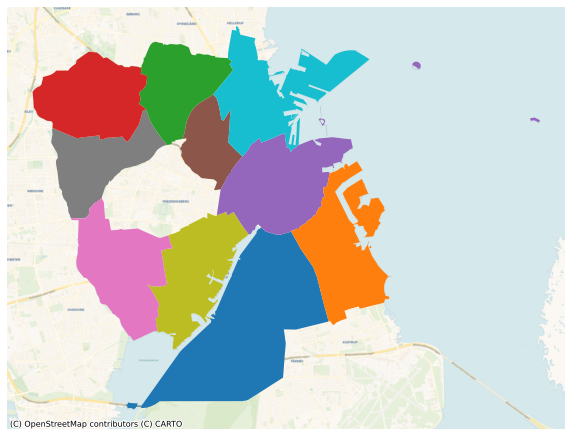

In [23]:
geo_df = geo_df.to_crs(epsg=3857)

ax = geo_df.plot(figsize=(10, 10), column = 'navn')

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)

ax.set_axis_off()

In [5]:
# Import income data
df_income = pd.read_csv('data/avg-income-districts-cph.csv', encoding = "ISO-8859-1", sep=';')

In [6]:
df_income.head()

,district,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,District - Indre By,326988,345261,351173,362277,380598,398474,409033,422123,431152,457727
1,District - Østerbro,306248,309680,318321,325432,332546,345110,354481,363637,376002,392504
2,District - Nørrebro,232740,236408,240723,245021,251550,259959,266450,273494,281437,292139
3,District - Vesterbro/Kongens Enghave,267431,272759,281126,286305,295440,304436,312523,323748,337283,350601
4,District - Valby,274896,278852,284216,287020,292458,300856,304855,311108,320160,331929


In [7]:
# Clean district rows
df_income['district'] = df_income['district'].str[11:]

In [8]:
# Pivot data from wide to long format
df_income_long = (df_income.melt(id_vars = 'district', 
                                 var_name = 'year', 
                                 value_name = 'avg_income')) # https://towardsdatascience.com/reshape-pandas-dataframe-with-melt-in-python-tutorial-and-visualization-29ec1450bb02

In [9]:
df_income_long

,district,year,avg_income
0,Indre By,2010,326988
1,Østerbro,2010,306248
2,Nørrebro,2010,232740
3,Vesterbro/Kongens Enghave,2010,267431
4,Valby,2010,274896
...,...,...,...
95,Vanløse,2019,350027
96,Brønshøj-Husum,2019,316011
97,Bispebjerg,2019,278527
98,Amager Øst,2019,331012
